
Develop a fully connected autoencoder using PyTorch, comprising three encoder and three decoder layers. Train the autoencoder on the Street View House Numbers (SVHN) dataset and conduct a comprehensive evaluation of its reconstruction accuracy. Extend the autoencoder by incorporating a sparsity constraint on the hidden layer. Systematically assess the impact of sparsity on the learned representations and the overall reconstruction performance of the model. Provide insights into how the introduction of sparsity affects the autoencoder's ability to capture meaningful features and improve reconstruction quality.

In [3]:
from skimage.metrics import structural_similarity as ssim

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from math import log10, sqrt
import cv2
from skimage import metrics

from PIL import Image

In [5]:
batch_size = 50
learning_rate = 0.01
epochs = 10

In [6]:
#make everything on gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###Training and testing dataloaders

In [7]:
#Download the dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.SVHN(
    root="~/torch_datasets", transform=transform, download=True
)

#Splitting the dataset
train_set, test_set, val_set = torch.utils.data.random_split(dataset, [0.6 , 0.2 , 0.2])

#Data loaders
train_loader = torch.utils.data.DataLoader(
      train_set,batch_size=batch_size, shuffle=True
   )

test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=batch_size, shuffle=False
     )

val_loader = torch.utils.data.DataLoader(
      val_set, batch_size=batch_size, shuffle=False
     )

Using downloaded and verified file: /root/torch_datasets/train_32x32.mat


###Undercomplete Autoencoder

In [8]:
class UnderCompleteAutoencoder(nn.Module):
    def __init__(self,input_dim):
        super(UnderCompleteAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim*0.25)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.25), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.75)),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim*0.75), int(input_dim*0.5)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.5), int(input_dim*0.25)),
            nn.ReLU(),
            nn.Linear(int(input_dim*0.25), input_dim),
            nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
model = UnderCompleteAutoencoder(input_dim= 1024).to(device)

In [14]:
# mean-squared error loss
criterion = nn.MSELoss()

In [15]:
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
l1 = []
l2 = []

# training step
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 1024).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss

    l1.append(loss / len(train_loader))



    valid_loss_f = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for batch_features, _ in val_loader:
        # Transfer Data to GPU if available
        batch_features = batch_features.view(-1, 1024).to(device)

        # Forward Pass
        output = model(batch_features)
        # Find the Loss
        valid_loss = criterion(output, batch_features)
        # Calculate Loss
        valid_loss_f += valid_loss.item()
    l2.append(valid_loss_f / len(val_loader))






    # display the epoch training loss and Validation Loss
    # print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
    print(f'Epoch {epoch+1} \n \t\t Training Loss: { loss / len(train_loader)} \t\t Validation Loss: { valid_loss_f / len(val_loader)}')


Epoch 1 
 		 Training Loss: 0.015450826901095834 		 Validation Loss: 0.015261983451414473
Epoch 2 
 		 Training Loss: 0.01545575629094277 		 Validation Loss: 0.015258220376028699
Epoch 3 
 		 Training Loss: 0.015471150120720267 		 Validation Loss: 0.015287839288056708
Epoch 4 
 		 Training Loss: 0.015451027068775148 		 Validation Loss: 0.015258378792731534
Epoch 5 
 		 Training Loss: 0.015455308262343434 		 Validation Loss: 0.015265393907166257
Epoch 6 
 		 Training Loss: 0.015458624250128526 		 Validation Loss: 0.015321587291577843
Epoch 7 
 		 Training Loss: 0.01545052120716057 		 Validation Loss: 0.015276537634761764
Epoch 8 
 		 Training Loss: 0.015460532657082447 		 Validation Loss: 0.015336484524744506
Epoch 9 
 		 Training Loss: 0.01546152262228795 		 Validation Loss: 0.01526829342161413
Epoch 10 
 		 Training Loss: 0.015455717793454163 		 Validation Loss: 0.015282110779919998


In [66]:
l1

[0.015450826901095834,
 0.01545575629094277,
 0.015471150120720267,
 0.015451027068775148,
 0.015455308262343434,
 0.015458624250128526,
 0.01545052120716057,
 0.015460532657082447,
 0.01546152262228795,
 0.015455717793454163]

In [67]:
l2

[0.015261983451414473,
 0.015258220376028699,
 0.015287839288056708,
 0.015258378792731534,
 0.015265393907166257,
 0.015321587291577843,
 0.015276537634761764,
 0.015336484524744506,
 0.01526829342161413,
 0.015282110779919998]

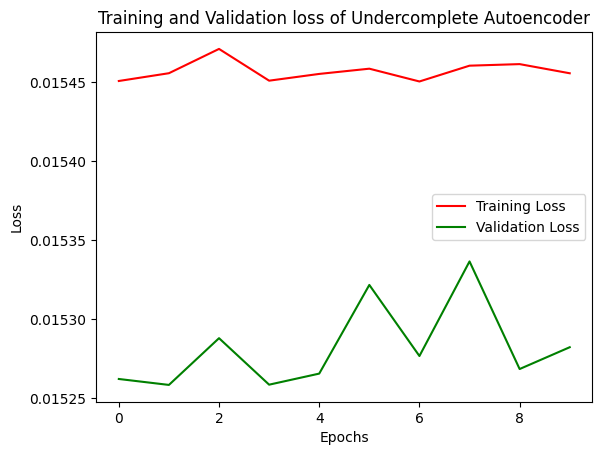

In [68]:
#Traning loss and Validation loss

plt.plot(l1, color='r', label='Training Loss')
plt.plot(l2, color='g', label='Validation Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss of Undercomplete Autoencoder")

plt.legend()
plt.show()

In [11]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr,mse


In [15]:
p = []
mse = []

In [ ]:
pip install torchmetrics

In [9]:
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [10]:
#calculating ssim using inbuilt function
metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
values = [ ]

In [ ]:
#Testing the dataset
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0].to(device)
        test_examples1 = batch_features.view(-1, 1024)
        # test_examples = batch_features.view(batch_features.size(0), -1)
        reconstruction = model(test_examples1)
        # print(reconstruction.shape)
        # print(batch_features.shape)
        # print(test_examples.shape)

        ori = np.array(batch_features.cpu())
        fi = np.array(reconstruction.cpu())



        # print(ori.shape)
        print(fi.shape)

        if fi.size == 3072 or len(test_examples1) == 3:
            break
        else:
            fi = fi.reshape(50, 3 , 32 , 32)
            evl = PSNR(ori, fi)

            reshaped_tensor = reconstruction.view(50, 3 , 32, 32)
            #storing ssim values
            values.append(metric(batch_features, reshaped_tensor))
            #storing mse and PSNR
            mse.append(float(evl[1]))
            p.append(float(evl[0]))

        # mse.append(float(torch.mean((test_examples - reconstruction) ** 2)))
        # psnr.append(evl)





In [20]:
values[1].item()

0.28031712770462036

In [21]:
print(p)

[66.30481652233819, 66.63959844048543, 66.71176659852264, 66.06701674178316, 66.80645441095868, 66.8421467284175, 66.45297141916399, 66.00341335830528, 66.64481437122839, 65.61903990878068, 65.76796013663122, 65.8138027238997, 66.04818896796695, 66.7470598448757, 67.3813619339837, 65.88481468951356, 65.46645865469327, 66.23139457524194, 66.15116922807081, 66.36481207738375, 65.69630918348219, 66.3233956888256, 66.78172133196783, 66.63136155142854, 66.60242967649518, 64.92746127132486, 67.20015949093515, 66.07119484992808, 65.84204788833284, 65.99086676285626, 65.80046246087481, 66.29542797071142, 66.88173102737872, 66.13840279304995, 66.45357448954448, 66.29200843179846, 67.2999378524305, 66.69068813841547, 66.47696909032577, 66.56233059046284, 65.7538878100903, 65.9568295932281, 66.2044023959424, 65.57215373267485, 65.87944183753513, 66.80420537546664, 65.89396386880034, 65.91328526186683, 66.39189482842741, 66.48509109205442, 66.23137394189895, 65.07914021892783, 65.26004765827689, 6

In [51]:
sum = 0
for i in range(len(p)):
    sum += p[i]

psnr_average = sum/len(p)
print(f'PSNR :{psnr_average}')

PSNR :66.26049302798162


In [52]:
sum = 0
for i in range(len(values)):
    sum += values[i].item()

ssim_average = sum/len(values)
print(f'SSIM :{ssim_average}')

SSIM :0.2836432553217476


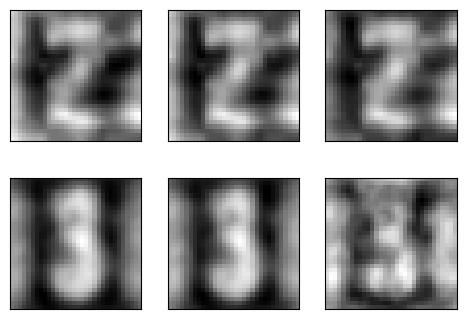

In [53]:
with torch.no_grad():
    number = 10

    plt.figure(figsize=(20, 4))
    for index in range(3):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples1[index].cpu().numpy().reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

###SparseAuto Endcoder

In [16]:
#Sparse loss function

reg_param = 1e-3
# get the layers of model as a list
model_children = list(model.children())
print(model_children)
# define the sparse loss function
def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    #range = 3 as we have 3 layers
    for i in range(3):
        fc = list(model.encoder.children())[2 * i]
        act = list(model.encoder.children())[2 * i + 1]
        values = act(fc(values))
        loss += torch.mean(torch.abs(values))
    for i in range(3):
        fc = list(model.decoder.children())[2 * i]
        act = list(model.decoder.children())[2 * i + 1]
        values = act(fc(values))
        loss += torch.mean(torch.abs(values))
    return loss

[Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=768, bias=True)
  (5): ReLU()
), Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1024, bias=True)
  (5): Sigmoid()
)]


In [17]:
l1_sparse = []
l2_sparse = []

# training step
for epoch in range(10):
    loss1 = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 1024).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction Sparse loss
        l1_loss = sparse_loss(model, batch_features)

        train_loss = criterion(outputs, batch_features) + l1_loss * reg_param

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss1 += train_loss.item()

    # compute the epoch training loss
    loss = loss1 / len(train_loader)

    l1_sparse.append(loss1/ len(train_loader))




    valid_loss_f = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in val_loader:
        # Transfer Data to GPU if available
        batch_features = batch_features.view(-1, 1024).to(device)

        # Forward Pass
        output = model(batch_features)

        l1_loss = sparse_loss(model, batch_features)
        # Find the Loss
        valid_loss = criterion(outputs, batch_features) + l1_loss * reg_param
        # Calculate Loss
        valid_loss_f += valid_loss.item()
    l2_sparse.append(valid_loss_f / len(val_loader))




    # display the epoch training loss and Validation Loss
    # print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
    print(f'Epoch {epoch+1} \n \t\t Training Loss: { loss1 / len(train_loader)} \t\t Validation Loss: { valid_loss_f / len(val_loader)}')

    # display the epoch training loss
    # print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

Epoch 1 
 		 Training Loss: 0.01760553998279978 		 Validation Loss: 0.009436112828552723
Epoch 2 
 		 Training Loss: 0.016013410351958805 		 Validation Loss: 0.012310126796364784
Epoch 3 
 		 Training Loss: 0.015975297083654864 		 Validation Loss: 0.01860472746193409
Epoch 4 
 		 Training Loss: 0.015977416594978422 		 Validation Loss: 0.010922681540250778
Epoch 5 
 		 Training Loss: 0.015967730912168257 		 Validation Loss: 0.011826088652014732
Epoch 6 
 		 Training Loss: 0.015921037649439477 		 Validation Loss: 0.009842709638178349
Epoch 7 
 		 Training Loss: 0.01597598964475434 		 Validation Loss: 0.019484838470816612
Epoch 8 
 		 Training Loss: 0.015906279885464093 		 Validation Loss: 0.010303502902388573
Epoch 9 
 		 Training Loss: 0.015927168829578228 		 Validation Loss: 0.014959705993533134
Epoch 10 
 		 Training Loss: 0.015929113145367328 		 Validation Loss: 0.01008519809693098


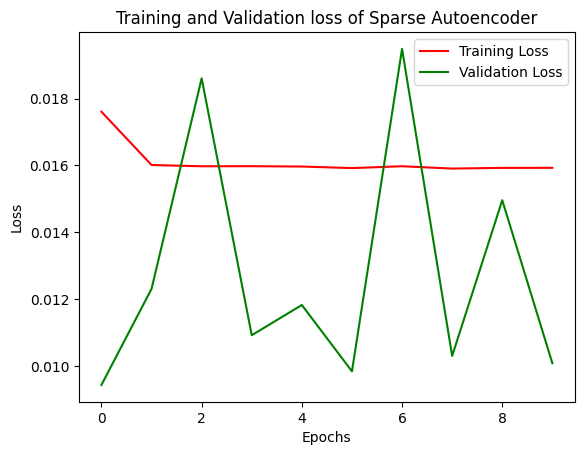

In [18]:
#Traning loss and Validation loss

plt.plot(l1_sparse, color='r', label='Training Loss')
plt.plot(l2_sparse, color='g', label='Validation Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss of Sparse Autoencoder")

plt.legend()
plt.show()

In [19]:
mse_sparse = []
p_sparse = []
values_sparse = []

In [ ]:
#Testing the dataset
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0].to(device)
        test_examples = batch_features.view(-1, 1024)

        # test_examples = batch_features.view(batch_features.size(0), -1)
        reconstruction = model(test_examples)
        # print(reconstruction.shape)
        # print(batch_features.shape)
        # print(test_examples.shape)

        ori = np.array(batch_features.cpu())
        fi = np.array(reconstruction.cpu())



        # print(ori.shape)


        if fi.size == 3072 or len(test_examples) == 3 :
            break
        else:
            fi = fi.reshape(50, 3 , 32 , 32)
            evl = PSNR(ori, fi)

            reshaped_tensor = reconstruction.view(50, 3 , 32, 32)
            #storing ssim values
            values_sparse.append(metric(batch_features, reshaped_tensor))
            #storing mse and PSNR
            mse_sparse.append(float(evl[1]))
            p_sparse.append(float(evl[0]))
        print(fi.shape)
        print(len(test_examples))
        # mse.append(float(torch.mean((test_examples - reconstruction) ** 2)))
        # psnr.append(evl)


In [ ]:
p_sparse

In [21]:
sum_sparse = 0
for i in range(len(p_sparse)):
    sum_sparse += p_sparse[i]

psnr_average = sum_sparse/len(p_sparse)
print(f'PSNR_Sparse :{psnr_average}')

PSNR_Sparse :66.28274958850136


In [22]:
sum = 0
for i in range(len(values_sparse)):
    sum += values_sparse[i].item()

ssim_average = sum/len(values_sparse)
print(f'SSIM_SPARSE:{ssim_average}')

SSIM_SPARSE:0.2813498921463514


In [44]:
len(test_examples)

3

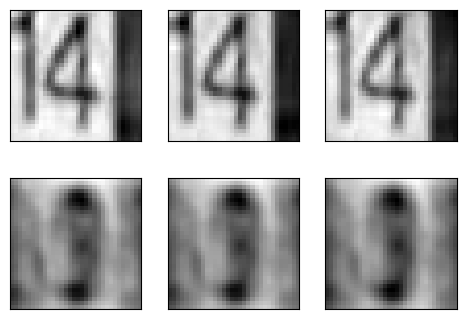

In [23]:
with torch.no_grad():
    number = 10

    plt.figure(figsize=(20, 4))
    for index in range(3):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

*   Sparsity encourages the autoencoder to learn a more compact and efficient representation of the input data.
*   By enforcing sparsity, the autoencoder is encouraged to use only a subset of neurons for encoding, leading to a more concise representation.

Since I had trained the model for only 10 epochs, there isnt significant improvement in ssim and psnr values but after inducing sparsity the SSIM and PSNR values should be improved.


